# Snapshot Data Reduction Scripts

The two functions provided reduce snapshot info a readable format for the SKIRT radiative transfer code and make simple projections of snapshot data for by eye visualizations.

In [13]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import importlib.util

from crc_scripts.utils.stellar_hsml_utils import get_particle_hsml
from crc_scripts.figure import Projection
from crc_scripts.io.gizmo import load_halo
import crc_scripts.utils.data_calc_utils as calc

def create_SKIRT_particle_files(snap_dir, snap_num, output_dir, import_dust=False, import_dust_hsml=True, use_halo_file=False, star_file_name='stars.dat', dust_file_name='dust.dat', max_box_coords=None):
    '''
    This function extracts and reduces the star and gas particle data from the specified simulation snapshot 
    into SKIRT input file. When extracting dust data it only uses the dust-to-metals (D/Z) ratio.

    Parameters
    ----------
    snap_dir : string
        Name of snapshot directory
    snap_num : int
        Snapshot number
    output_dir : string
        Name of directory where SKIRT outputs will be written to
    import_dust : boolean
        Sets whether dust mass will be extracted from simulation. Otherwise a constant D/Z 
        ratio is assumed by SKIRT.
    import_dust_hsml : boolean
        Sets whether gas/dust smoothing length will be extracted from simulation. This is used by 
        SKIRT when building an octotree grid for the dust medium. Set to False if using the 
        Voronoi grid since each particle position is used to make a Voronoi tesselation.
    use_halo_file : string, optional
        Use halo files (i.e. AHF) to initially center halo. Only really needed for high-z or subhalos.
    star_file_name : string
        Name of file for star particle data.
    dust_file_name : string
        Name of file for gas particle data.
    max_box_coords : list of floats, optional
        List of maximum x, y, z coordinates in kpc of star and gas/dust particles to be exported. 
        If None, all particles are included. If provided, the list should be in the form 
        [max_x, max_y, max_z].
    '''
    # This loads the galactic halo from the snapshot
    mode='AHF' if use_halo_file else None
    halo = load_halo(snap_dir, snap_num, mode=mode)
    # This orientates the halo so that the galactic disk is face-on
    print("Orientating halo")
    halo.set_orientation()

    if not halo.sp.Flag_DustSpecies and import_dust:
        print("WARNING: import_dust set to True but this snapshot does not have dust. Set import_dust to False.")

    # Load data for star particles (ptype = 4)
    # For idealized sims, the initial stars are stored as ptype = 2 and 3 and need to be appended
    if not halo.sp.cosmological: append_dummies=True
    else: append_dummies=False
    p4 = halo.loadpart(4, append_dummies=append_dummies)

    
    # Compute the star softening lengths. This takes some time.
    # Do this before mask so softening length are correct for all particles.
    coords = p4.get_property('position')
    x, y, z = coords[:,0], coords[:,1], coords[:,2]
    print("Calculating star particle smoothing lengths...")
    h = get_particle_hsml(x, y, z)

    if max_box_coords is not None:
        coords = p4.get_property('position')
        x, y, z = coords[:,0], coords[:,1], coords[:,2]
        mask = (np.abs(x) <= max_box_coords[0]) & (np.abs(y) <= max_box_coords[1]) & (np.abs(z) <= max_box_coords[2])
        print(f"Applying mask to star particles with max box coordinates {max_box_coords} kpc")
        p4.mask(mask)
        h = h[mask]

    # x,y,x coordinates
    coords = p4.get_property('position')
    x, y, z = coords[:,0], coords[:,1], coords[:,2]

    spam_spec = importlib.util.find_spec("gizmo_analysis")
    has_gizmo_analysis = spam_spec is not None

    if has_gizmo_analysis:
        # mass at formation, metallicity, and age
        m, Z, t = p4.get_property('M_form'), p4.get_property('Z_all')[:,0], 1e9*p4.get_property('age')
    else:
        print("WARNING: gizmo_analysis not installed. This module is needed to determine the zero-age stellar mass which SKIRT expects for star particles.")
        print("This will instead use the current star mass, which can underestimate the mass by <=30%.")
        print("You can pip install gizmo_analysis @ https://git@bitbucket.org/awetzel/gizmo_analysis.git")
        # current mass , metallicity, and age
        m, Z, t = p4.get_property('M'), p4.get_property('Z_all')[:,0], 1e9*p4.get_property('age')
    
    f = open(output_dir+"/"+star_file_name, 'w')
    # Write header for star file
    header =    '# star.dat \n' + \
                '# Column 1: position x (pc)\n' + \
                '# Column 2: position y (pc)\n' + \
                '# Column 3: position z (pc)\n' + \
                '# Column 4: smoothing length (pc)\n' + \
                '# Column 5: mass (Msun)\n' + \
                '# Column 6: metallicity (1)\n' + \
                '# Column 7: age (yr)\n'
    f.write(header)
    # Step through each star particle and write its data
    for i in range(p4.npart):
        line = "%.2f %.2f %.2f %.2f %.3e %.3e %.3e\n" %(1e3*x[i],1e3*y[i],1e3*z[i],1e3*h[i],m[i],Z[i],t[i])
        f.write(line)
    f.close()

    print(f"Star data written to {star_file_name}...")

    # Load gas particle data (ptype = 0)
    p0 = halo.loadpart(0)

    if max_box_coords is not None:
        coords = p0.get_property('position')
        x, y, z = coords[:,0], coords[:,1], coords[:,2]
        mask = (np.abs(x) <= max_box_coords[0]) & (np.abs(y) <= max_box_coords[1]) & (np.abs(z) <= max_box_coords[2])
        print(f"Applying mask to gas particles with max box coordinates {max_box_coords} kpc")
        p0.mask(mask)

    # x,y,x coordinates
    coords = p0.get_property('position')
    x, y, z = coords[:,0], coords[:,1], coords[:,2]
    # If the snapshots include dust amounts, give those to SKIRT and set D/Z to 1
    # Else just assume a constant D/Z everywhere.
    if import_dust:
        # smoothing length, dust mass, and temperature
        h, m, T = p0.get_property('size'), p0.get_property('M_dust'), p0.get_property('temperature')
    else:
        # smoothing length, gas mass, metallicity, and temperature
        h, m, Z, T = p0.get_property('size'), p0.get_property('M'), p0.get_property('Z_all')[:,0], p0.get_property('temperature')

    f = open(output_dir+"/"+dust_file_name, 'w')
    # Make header for gas/dust with data columns matching specified properties
    # Position is always needed, smoothing length depends on if you are using a grid or a voronoi tessellation
    # Mass depends on if you are import a dust mass tracked in the simulation or assuming a dust mass using
    # the gas mass and metallicity and an assumed dust-to-metals ratio such that Mdust = Mgas * Z * D/Z.
    # Temperature is used as a cut off for dust mass. Anything above a set temperature is assumed to have no dust.
    header =   '# gas.dat \n' + \
               '# Column 1: position x (pc)\n' + \
               '# Column 2: position y (pc)\n' + \
               '# Column 3: position z (pc)\n'
    if import_dust and import_dust_hsml:
        header += '# Column 4: smoothing length (pc)\n' + \
                  '# Column 5: dust mass (Msun)\n' + \
                  '# Column 6: temperature (K)\n'
    elif import_dust:
        header += '# Column 4: dust mass (Msun)\n' + \
                  '# Column 5: temperature (K)\n'
    elif import_dust_hsml:
        header += '# Column 4: smoothing length (pc)\n' + \
                  '# Column 5: mass (Msun)\n' + \
                  '# Column 6: metallicity (1)\n' + \
                  '# Column 7: temperature (K)\n'
    else:
        header += '# Column 4: mass (Msun)\n' + \
                  '# Column 5: metallicity (1)\n' + \
                  '# Column 6: temperature (K)\n'   

    f.write(header)

    if import_dust and import_dust_hsml:
        for i in range(p0.npart):
            line = "%.2f %.2f %.2f %.3e %.3e %.3e\n" %(1e3*x[i],1e3*y[i],1e3*z[i],1e3*h[i],m[i],T[i])
            f.write(line)
    elif import_dust:
        for i in range(p0.npart):
            line = "%.2f %.2f %.2f %.3e %.3e\n" %(1e3*x[i],1e3*y[i],1e3*z[i],m[i],T[i])
            f.write(line)       
    elif import_dust_hsml:
        for i in range(p0.npart):
            line = "%.2f %.2f %.2f %.3e %.3e %.3e %.3e\n" %(1e3*x[i],1e3*y[i],1e3*z[i],1e3*h[i],m[i],Z[i],T[i])
            f.write(line)     
    else:
        for i in range(p0.npart):
            line = "%.2f %.2f %.2f %.3e %.3e %.3e\n" %(1e3*x[i],1e3*y[i],1e3*z[i],m[i],Z[i],T[i])
            f.write(line)
    f.close()

    print(f"Gas/Dust data written to {dust_file_name}...")

def create_galaxy_projection(snap_dir, snap_num, foutname='snap_projection.png', use_halo_file=False, pixel_res=0.05, proj_L=15, properties=['sigma_gas'], prop_limits=[], prop_cmaps=[],
                            log_cmaps=[] ,labels=[], sub_proj=False, sub_L=8):
    '''
    This function takes the specified snapshot and makes a projection of the specified properties. The property can either be a surface density (i.e sigma_gas)
    or the median a physical property (i.e. temperature). The default projection is face-on with the galaxy (x-y axis), but you can add a subb-projection 
    along another direction (x-z,y-z).

    Parameters
    ----------
    snap_dir : string
        Name of snapshot directory
    snap_num : int
        Snapshot number
    foutname: string
        Name of file for saved image.
    use_halo_file : string, optional
        Use halo files (i.e. AHF) to initially center halo. Only really needed for high-z or subhalos.
    pixel_res : double
        Size of each projection pixel in kpc. If this is too small you will start to bin individual particles.
    properties : list
        List of properties you want individual projections for. Check the crc_scripts.config.PROP_INFO dictionary for supported properties.
    prop_limits : list
        List of lower and upper limits for each property.
    prop_cmaps : list
        List of colormaps for each property.
    log_cmaps : list
        List setting if colormap should be in log space for each property.
    label : list
        List of labels which will appear in the corner for each projection.
    proj_L : double
        Sets the size of each projection in kpc (for reference the Milky Way has a disk size of ~10 kpc).
    sub_proj : bool
        Sets whether you want another subprojection underneath the main projection with a projection angle that is  offset by 90 degrees.
    sub_L : double
        Sets the size of each subprojection in kpc (~5 kpc is good for a disk galaxy).
    
    '''

    mode='AHF' if use_halo_file else None
    halo = load_halo(snap_dir, snap_num, mode=mode)
    # Orientate the galaxy so it is face-on
    halo.set_orientation()
    # Initialize projection figure
    L = proj_L
    height_ratios = [L/sub_L,1]
    new_proj = Projection(len(properties), add_sub_proj=sub_proj, add_colorbars=True, height_ratios=height_ratios)
    # Create projections for each property and plot the projection
    for j,prop in enumerate(properties):
        new_proj.set_proj_axis(j, prop, L, axes_visible=False)
        # Create x-y projection using a 2D histogram
        main_pixel_stats, main_xedges, main_yedges, main_extent = calc.calc_projected_prop(prop, halo, [L,L,L], pixel_res=pixel_res, proj='xy')
        if sub_proj:
            # Create x-z subprojection using a 2D histogram
            sub_pixel_stats, sub_xedges, sub_yedges, sub_extent = calc.calc_projected_prop(prop, halo, [L,sub_L,L], pixel_res=pixel_res, proj='xz')
        else:
            sub_pixel_stats=None; sub_extent=None
        # x-z projection
        # Create the projection
        if labels is not None:
            label = labels[j]
        else:
            label=None
        new_proj.plot_projection(j, main_pixel_stats, main_extent, sub_proj_data=sub_pixel_stats, sub_extent=sub_extent,
                                 cmap= prop_cmaps[j], v_limits = prop_limits[j],v_log=log_cmaps[j], label=label)

    new_proj.save(foutname)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Reduce snapshot data

Depending on how you setup SKIRT, you will need to reduce specific properties for gas and star particles from a snapshot. Below are two ways you can modify SKIRT which is supported by the snapshot reduction script.

1. Dust/Gas Mass: inferred vs direct dust medium

    SKIRT can work with either a direct dust mass given for each gas cell in the snapshot (such as for simulations with the Choban+2022 dust evolution model) or it can infer the dust mass for each gas cell. To infer the dust mass SKIRT needs the gas cell mass, metallicity, and an assumed fraction of the metal mass in dust (i.e. dust-to-metals ratio; D/Z) which is set in the SKIRT setup file. The equation SKIRT uses to infer the dust mass is $$M_{\rm dust} = M_{\rm gas} \times Z \times D/Z$$

    If you are running SKIRT with inferred dust, set `import_dust=False`.


2. Medium spatial grid: postprocessed Octotree vs Voronoi tesselation 

    Given gas/dust cell data (positions and cell size), SKIRT can create an octotree grid fitted to the data ([see SKIRT user guide for details](https://skirt.ugent.be/root/_tutorial_grids_tree_voro.html])). This will increase the SKIRT simulation runtime substantially and it can be difficult for the grid to converge. Another method is to create a Voronoi tesselation. In this case SKIRT only needs the gas cell positions, which it then uses to create a Voronoi tesselation grid. We find this converges well (based on SKIRTs convergence probe) and decreases the runtime.

    If you are running SKIRT with the octotree grid, set `import_dust_hsml=True` to reduce gas cell sizes. Set `import_dust_hsml=False` for Voronoi tesselation.

#### Important on particle data and the SKIRT source and medium system.

The user specifies the dimensions of the gas/dust medium grid for SKIRT which does not have to be the entire volume filled by your cell data. SKIRT will discard any cells outside the specified dimensions before making the medium grid. However, it will still keep all source particles! For example, if you provide the entire star and gas/dust data for a galaxy snapshot but specify a medium grid which spans a 1 kpc box around the galactic center, all of the gas/dust data outside the 1 kpc box will be ignored but all of the star particle will still be included in the luminosity calculations! To avoid  this, use the `max_box_coords` argument to only include star and gas/dust particle data in the desired box.


In [14]:
# Path to simulation snapshots
snap_dir = '/N/project/choban_group/hswang/FIRE2/m12i_res7100/output'
# Number of snapshot you want to open
snap_num = 600
# Path you want to save reduced data to
output_dir = './'
# Do you have a halo finder file (i.e. AHF) to center the galaxy on?
use_halo_file=False
# Set whether you want to import the dust mass from the simulation directly (only use this if the simulation has live dust) or 
# only import the gas mass and metallicity to be used with an assumed dust-to-metals ratio
import_dust = False
# Set whether you want to import the gas smoothing length from the simulation directly. Only use this if you are having SKIRT build a grid
# like an octotree. If you are using the Voronoi tesselation set to False.
import_dust_hsml = False

# Maximum box coordinates in kpc of star and gas/dust particles to be exported relative to galactic center. If None, all particles are included.
max_box_coords = [10,10,5] 

# Names for the star and dust/gas particle data.
# If you change these you need to change the names in the SKIRT input file as well.
box_string = f"x{max_box_coords[0]}_y{max_box_coords[1]}_z{max_box_coords[2]}"
star_file_name = 'stars_'+box_string+'.dat'
dust_file_name = 'dust_'+box_string+'.dat'


create_SKIRT_particle_files(snap_dir, 
                            snap_num, 
                            output_dir, 
                            import_dust=import_dust,
                            import_dust_hsml=import_dust_hsml,
                            use_halo_file=use_halo_file,
                            star_file_name=star_file_name,
                            dust_file_name=dust_file_name,
                            max_box_coords=max_box_coords)

/N/project/choban_group/hswang/FIRE2/m12i_res7100/output/snapdir_600/snapshot_600.0.hdf5
Centering galaxy on median position of gas particles with nH>10 cm^-3.
Orientating halo
assigning center of galaxy:
  center position [kpc] = 41787.786, 44126.630, 46262.852
  center velocity [km/s] = -52.5, 71.9, 95.2
assigning principal axes:
  using ptype 4 particles at radius < 10 kpc
  using ptype 4 particles with age = [0, 1] Gyr
  axis ratios:  min/maj = 0.086, min/med = 0.090, med/maj = 0.961
Calculating star particle smoothing lengths...
Applying mask to star particles with max box coordinates [10, 10, 5] kpc
Star data written to stars_x10_y10_z5.dat...
Applying mask to gas particles with max box coordinates [10, 10, 5] kpc
Gas/Dust data written to dust_x10_y10_z5.dat...


## Create projection visualization

The code below makes a simple projection of the gas, stars, and dust (if tracked in the simulation) for the specified snapshot. Use this to check if you are centered on your galaxy.

/N/project/choban_group/hswang/FIRE2/m12i_res7100/output/snapdir_600/snapshot_600.0.hdf5
Centering galaxy on median position of gas particles with nH>10 cm^-3.
assigning center of galaxy:
  center position [kpc] = 41787.786, 44126.630, 46262.852
  center velocity [km/s] = -52.5, 71.9, 95.2
assigning principal axes:
  using ptype 4 particles at radius < 10 kpc
  using ptype 4 particles with age = [0, 1] Gyr
  axis ratios:  min/maj = 0.086, min/med = 0.090, med/maj = 0.961
Property M_dust given to Particle with ptype 0 is not supported. Returning -1 array.
Property M_dust given to Particle with ptype 0 is not supported. Returning -1 array.


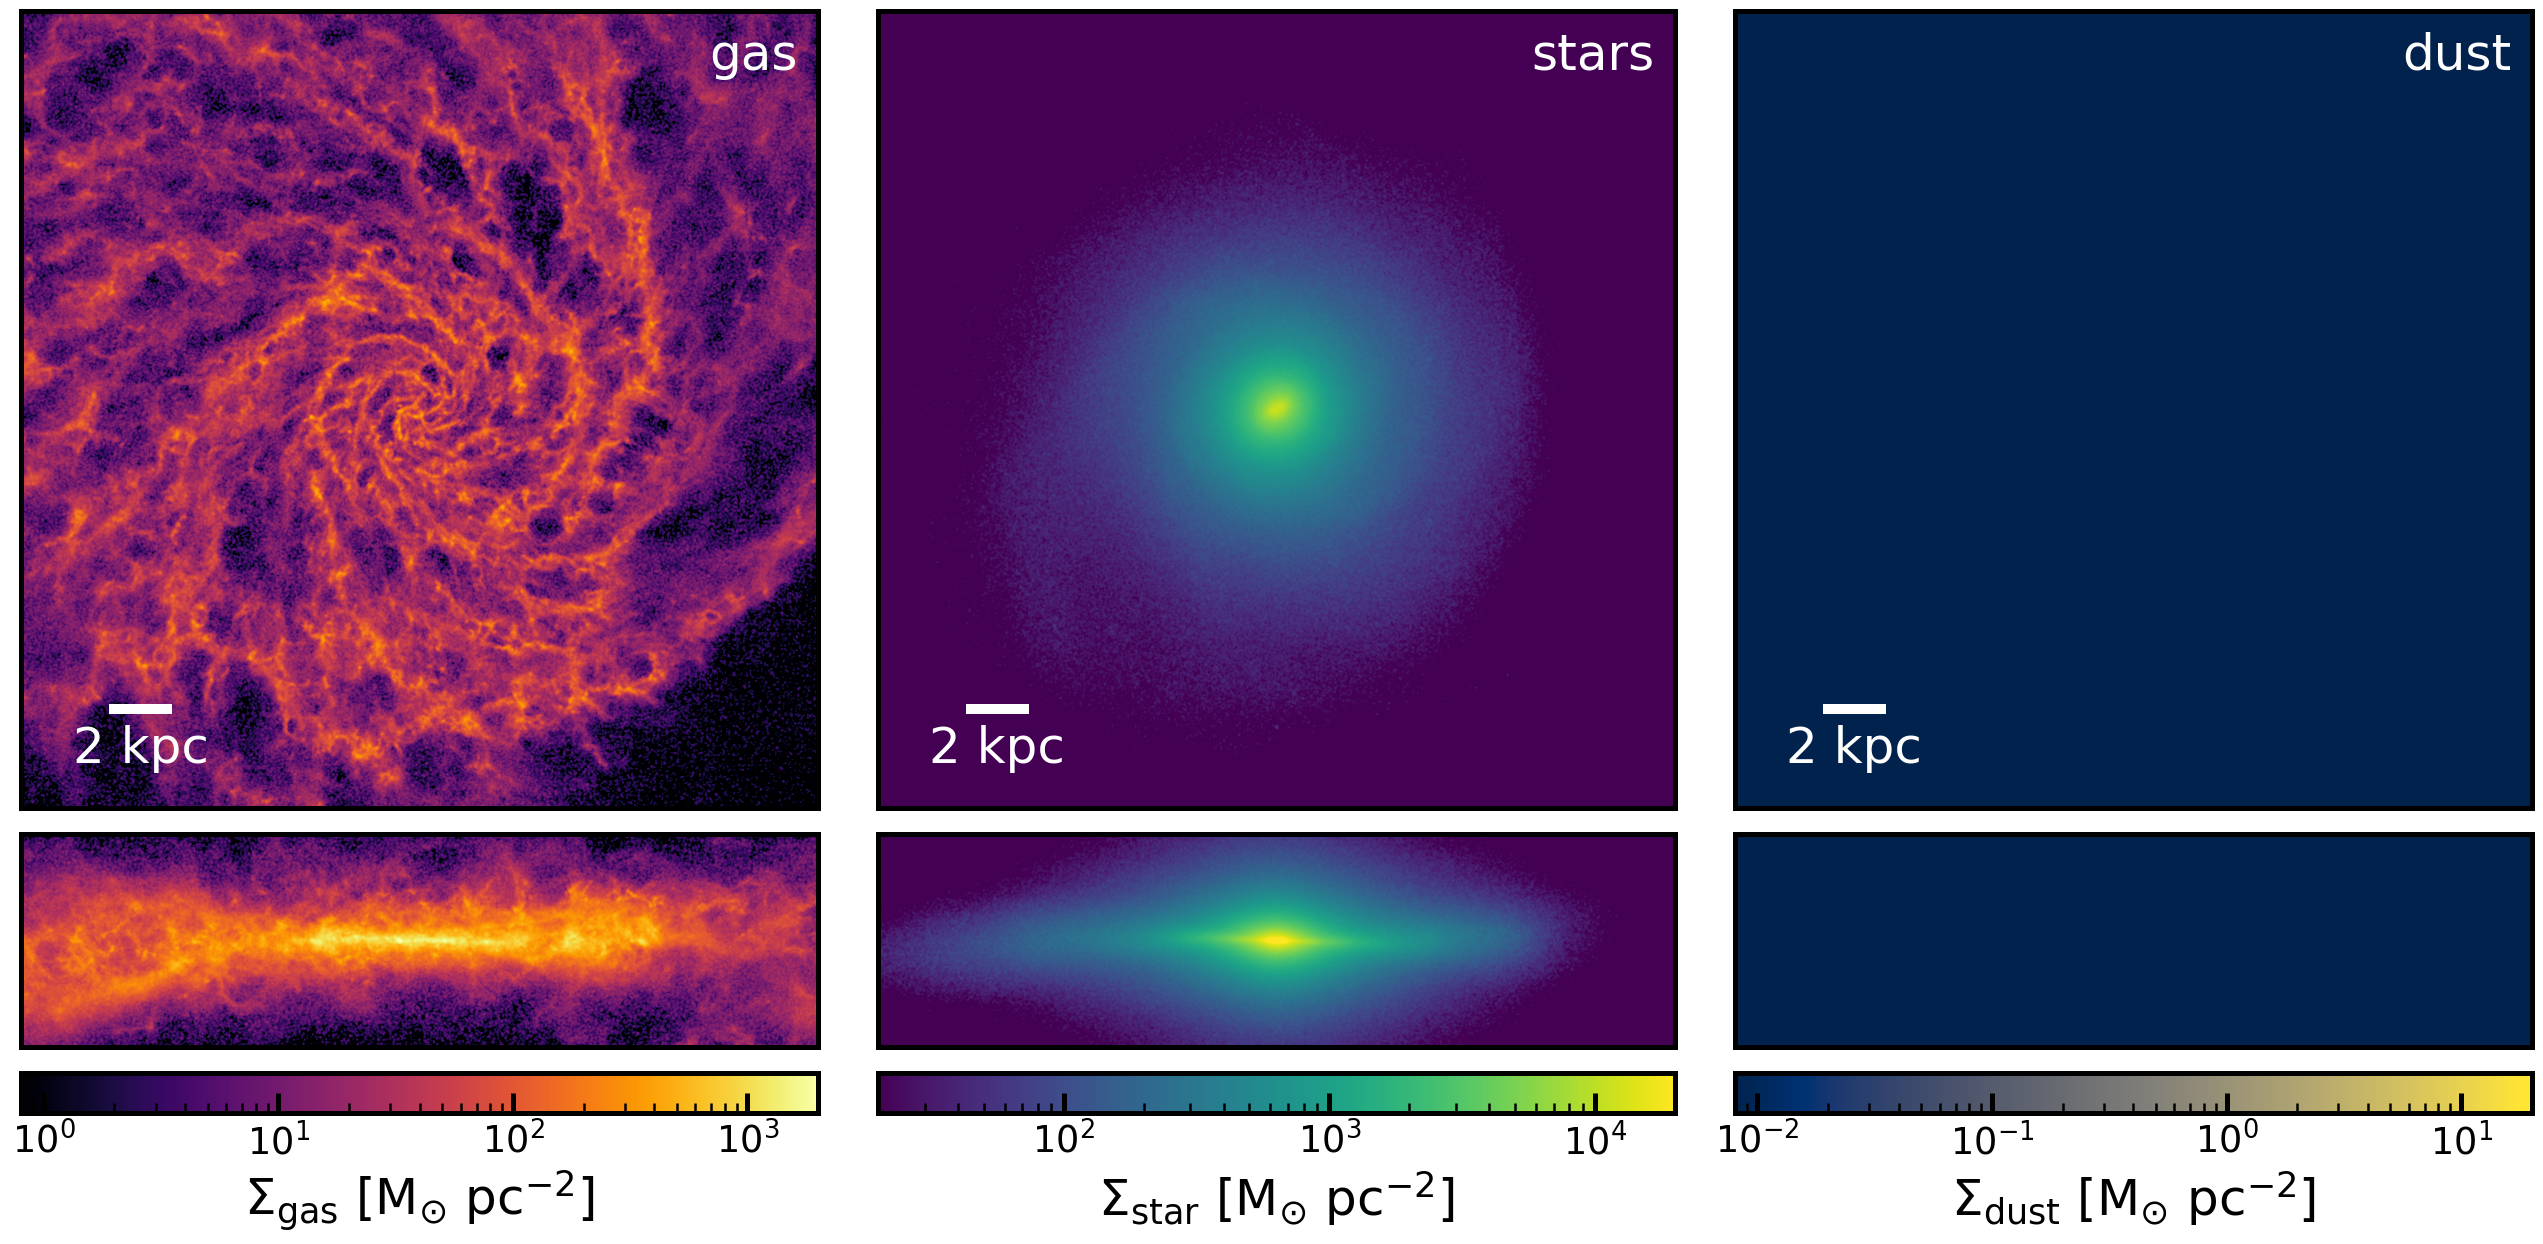

In [2]:
snap_dir = '/N/project/choban_group/hswang/FIRE2/m12i_res7100/output'
# Number of snapshot you want to open
snap_num = 600
use_halo_file=False
foutname = 'm12i_FIRE2_projection.png'

# Physical size of projection 
proj_L = 20 # kpc
# Size resolution (kpc) for each "pixel" in projection
pixel_res=0.05
# Properties to plot projections of. Can be surface densities (total mass in pixel divied by pixel size) or properties like T (median value of all particles in pixel)
properties = ['sigma_gas','sigma_star','sigma_dust']
# Limits for projection of each property. Defaults if not set
prop_limits = [[8E-1,2E3],[2E1,2E4],[8E-3,2E1]]
# Colormaps for each projection
prop_cmaps = ['inferno','viridis','cividis']
# Do you want log colormaps for each property (default = True)
log_cmaps = [True]*len(properties)
# Labels for each projection is so desired
labels = ['gas','stars','dust']
# Physical size of projection 
proj_L = 30 # kpc
# Do you want a secondary projection from an orthogonal axis (i.e. edge-on)
sub_proj = True
# size of secondary projection
sub_L = 8 # kpc

create_galaxy_projection(snap_dir, snap_num, use_halo_file=use_halo_file, proj_L=proj_L, pixel_res=pixel_res, foutname=foutname,
                            properties=properties, prop_limits=prop_limits, prop_cmaps=prop_cmaps,
                            log_cmaps=log_cmaps ,labels=labels, sub_proj=sub_proj, sub_L=sub_L)